### Import dependencies

In [138]:
# import dependencies
import os
import warnings
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import datetime
from typing import List
from scipy.fft import fft
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.tsatools import detrend
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


### Load Data

In [139]:
def load_data(path: str, target:str) -> pd.DataFrame:
    assert target in ["gm", "vix", "sp500", "gold", "eurusd", "bonds"], f"Invaid target: {target}"

    root = os.path.dirname(os.getcwd())
    df = pd.read_csv(f"{root}/{path}")

    # rename columns to lower case
    df.columns = map(str.lower, df.columns)
    if target == "gm":
        index = "business date"
    else:
        index = "date"
    new_columns = ["date"] + [column + f"_{target}" for column in df.columns if column != index]
    # Add _target to columns except Date
    df.rename(columns=dict(zip(df.columns, new_columns)),inplace=True)
    # Remove space from columns
    df.columns = df.columns.str.replace(" ", "_")
    return df.set_index("date")

def join_dfs(df_list: List) -> pd.DataFrame:
    pdf = df_list[0]
    for df in df_list[1:]:
        pdf = pdf.join(df, how="left")
    assert len(pdf) == len(df_list[0])
    return pdf

In [140]:
global_markets_volumes_path = "data/VOLUMES.csv"
vix_path = "data/VIX.csv"
sp500_path = "data/SP500.csv"
gold_path= "data/GOLD.csv"
euro_usd_path = "data/EURUSD.csv"
bonds_path = "data/10YBONDYIELDS.csv"

In [141]:
gm_volumes = load_data(global_markets_volumes_path, "gm")
vix = load_data(vix_path, "vix")
sp500 = load_data(sp500_path, "sp500")
gold = load_data(gold_path, "gold")
euro_usd = load_data(euro_usd_path, "eurusd")
bonds = load_data(bonds_path, "bonds")

In [142]:
all_dfs = [gm_volumes, vix, sp500, gold, euro_usd, bonds]
all_data = join_dfs(all_dfs)
all_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,volume_bonds
date,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,0.0
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,0.0
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,0.0
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,0.0
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,0.0
...,...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,0.0
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,0.0
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200,0.0


In [143]:
no_vol_bonds_df = all_data.drop(columns="volume_bonds")
no_vol_bonds_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130
...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200


<Axes: xlabel='date'>

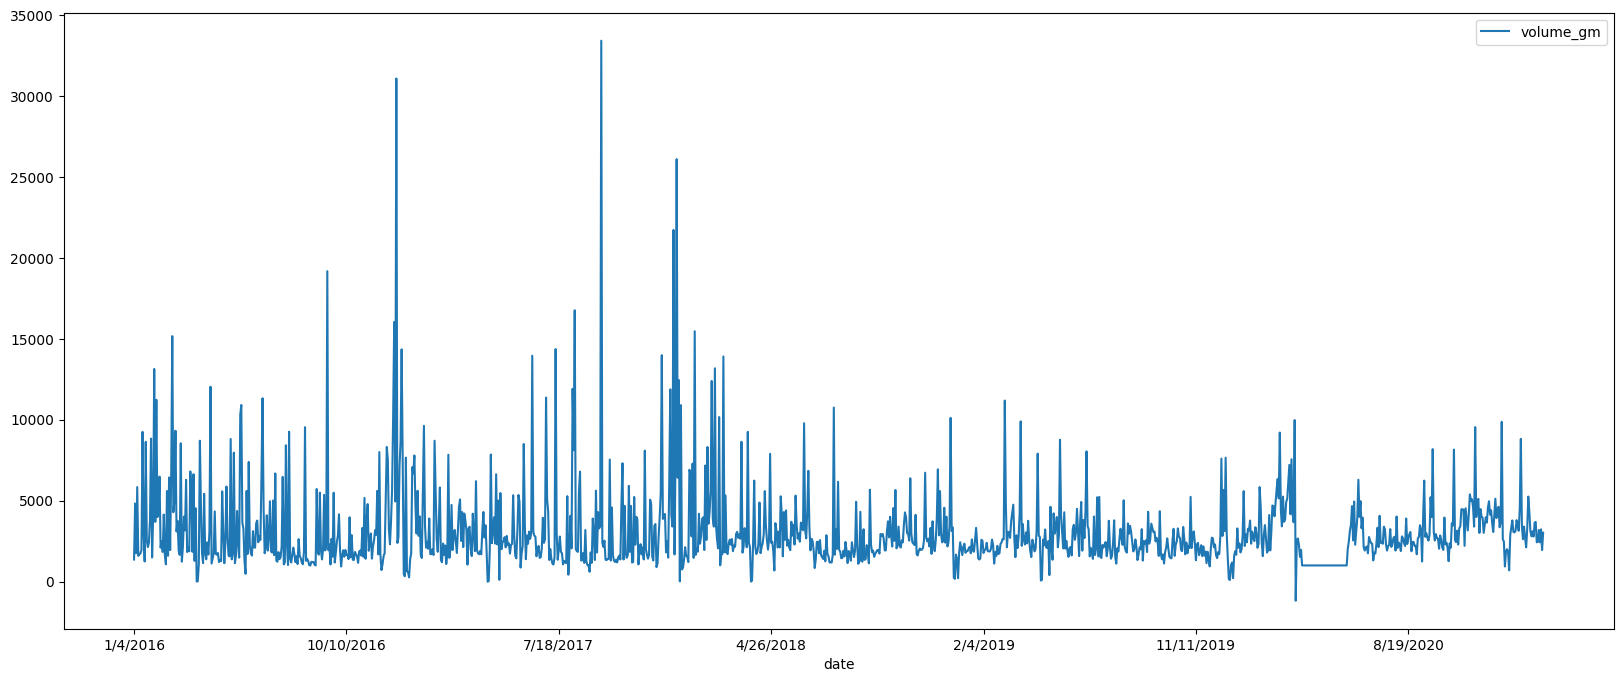

In [144]:
no_vol_bonds_df.plot(y='volume_gm', figsize=[20, 8])

In [145]:
# Remove constant line
removed_constant = no_vol_bonds_df[no_vol_bonds_df["volume_gm"] != 1000]

<Axes: xlabel='date'>

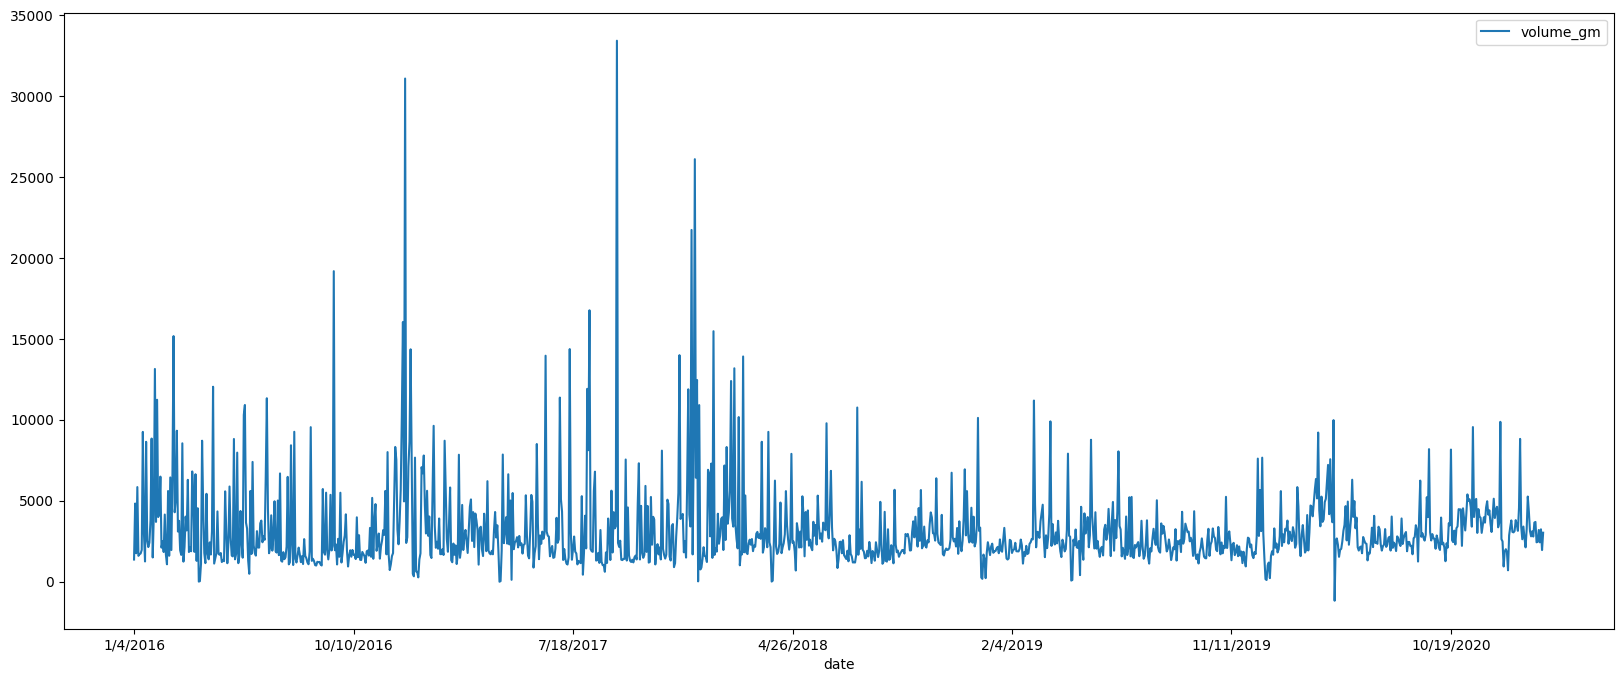

In [146]:
removed_constant.plot(y='volume_gm', figsize=[20, 8])

In [164]:
# Add target
sml_data = removed_constant.copy()
sml_data["sml_target"] = sml_data["volume_gm"].shift(-1)
sml_data = sml_data.iloc[:-1]
sml_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target
date,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,4826.624586
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,1751.952884
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,5842.829025
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,1592.794266
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,1692.648636
...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.63,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.157,3190.066116
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,2427.720356
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,3232.310708


In [165]:
def day_of_week(date_str):
    date_obj = datetime.strptime(date_str, '%m/%d/%Y')
    day_num = date_obj.weekday()  # 0 for Monday, 1 for Tuesday, ..., 6 for Sunday
    return day_num


def day_of_month(date_str):
    return int(date_str.split("/")[1])


def get_month(date_str):
    return int(date_str.split("/")[0])

In [166]:
sml_data["day_of_week"] = list(map(day_of_week, sml_data.index.tolist()))
sml_data["day_of_month"] = list(map(day_of_month, sml_data.index.tolist()))
sml_data["month"] = list(map(get_month, sml_data.index.tolist()))
sml_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,4826.624586,0,4,1
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,1751.952884,1,5,1
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,5842.829025,2,6,1
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,1592.794266,3,7,1
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,1692.648636,4,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.63,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.157,3190.066116,1,9,2
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,2427.720356,2,10,2
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,3232.310708,3,11,2


### Train Test split

In [167]:
def get_train_test_indexes(df: pd.DataFrame, test_size: float):
    test_len = int(df.shape[0] * test_size)
    train_len = int(df.shape[0] - test_len)
    train_indexes = list(range(train_len))
    test_indexes = list(range(train_len, df.shape[0]))
    return train_indexes, test_indexes

In [168]:

train_indexes, test_indexes = get_train_test_indexes(sml_data, 0.2)
train_indexes = [list(sml_data.index)[index] for index in train_indexes]
test_indexes = [list(sml_data.index)[index] for index in test_indexes]

In [169]:
train_indexes[0], train_indexes[-1]

('1/4/2016', '12/18/2019')

In [170]:
test_indexes[0], test_indexes[-1]

('12/19/2019', '2/15/2021')

In [171]:
train_df = sml_data.loc[train_indexes]
test_df = sml_data.loc[test_indexes]
train_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,4826.624586,0,4,1
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,1751.952884,1,5,1
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,5842.829025,2,6,1
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,1592.794266,3,7,1
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,1692.648636,4,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12/12/2019,2801.251674,13.94,3168.570068,3.990690e+09,1466.699951,955.0,1.1137,1.897,7602.639390,3,12,12
12/13/2019,7602.639390,12.63,3168.800049,3.736870e+09,1475.599976,468.0,1.1174,1.819,2824.129756,4,13,12
12/16/2019,2824.129756,12.14,3191.449951,4.051790e+09,1475.000000,99.0,1.1146,1.892,5661.781395,0,16,12


In [172]:
test_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
12/19/2019,7661.701953,12.50,3205.370117,3.720450e+09,1478.199951,319.0,1.1117,1.908,2963.764072,3,19,12
12/20/2019,2963.764072,12.51,3221.219971,6.454270e+09,1474.699951,118.0,1.1097,1.917,1458.084698,4,20,12
12/23/2019,1458.084698,12.61,3224.010010,3.060610e+09,1482.500000,391.0,1.1075,1.935,151.678597,0,23,12
12/24/2019,151.678597,12.67,3223.379883,1.296540e+09,NaN,NaN,1.1080,NaN,101.194918,1,24,12
12/26/2019,101.194918,12.65,3239.909912,2.160680e+09,1509.300049,126.0,NaN,1.905,1012.628855,3,26,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.63,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.157,3190.066116,1,9,2
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,2427.720356,2,10,2
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,3232.310708,3,11,2


### Feature engineering

In [173]:
def add_lags(
        df:pd.DataFrame, 
        cols: List[str], 
        periods: List[int] = [1, 2, 3]
    ) -> tuple[pd.DataFrame, List]:
    lags_columns = []
    for col in cols:
        for lag in periods:
            feature_col_name = f"{col}_lag_{lag}"
            df[feature_col_name] = df.shift(lag)[col]
            lags_columns.append(feature_col_name)
    return df, lags_columns


def cap_outliers(df: pd.DataFrame, columns, means, stds, std_num=4):
    for column in columns:
        up_border = means[column] + std_num * stds[column]
        down_border = max(0, means[column] - std_num * stds[column])
        df[column] = df[column].clip(lower=down_border, upper=up_border)
    return df

In [174]:
train_df[train_df.isna().any(axis=1)] #49

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
1/18/2016,1245.635545,NaN,NaN,NaN,NaN,NaN,1.0892,NaN,8639.718373,0,18,1
2/15/2016,1070.457234,NaN,NaN,NaN,NaN,NaN,1.1180,NaN,5600.761557,0,15,2
3/25/2016,2.655447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.294602,4,25,3
3/28/2016,28.294602,15.24,2037.050049,2.809090e+09,1219.900024,33.0,NaN,1.870,1098.372638,0,28,3
5/30/2016,484.661910,NaN,NaN,NaN,NaN,NaN,1.1139,NaN,5602.542679,0,30,5
7/4/2016,1793.751342,NaN,NaN,NaN,NaN,NaN,1.1138,NaN,5013.145974,0,4,7
9/5/2016,5497.128904,NaN,NaN,NaN,NaN,NaN,1.1156,NaN,1948.029847,0,5,9
10/10/2016,1659.620194,13.38,2163.659912,2.916550e+09,NaN,NaN,1.1160,NaN,1654.882803,0,10,10
11/11/2016,1419.393454,14.17,2164.449951,4.988050e+09,NaN,NaN,1.0904,NaN,2171.444153,4,11,11


In [175]:
test_df[test_df.isna().any(axis=1)] #11

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
12/24/2019,151.678597,12.67,3223.379883,1.296540e+09,NaN,NaN,1.1080,NaN,101.194918,1,24,12
12/26/2019,101.194918,12.65,3239.909912,2.160680e+09,1509.300049,126.0,NaN,1.905,1012.628855,3,26,12
1/20/2020,2430.875748,NaN,NaN,NaN,NaN,NaN,1.1085,NaN,3267.579028,0,20,1
2/17/2020,1940.847546,NaN,NaN,NaN,NaN,NaN,1.0835,NaN,4114.897129,0,17,2
7/3/2020,1311.872306,NaN,NaN,NaN,NaN,NaN,1.1224,NaN,1791.726839,4,3,7
9/7/2020,1241.357114,NaN,NaN,NaN,NaN,NaN,1.1824,NaN,4031.184958,0,7,9
11/26/2020,3013.808951,NaN,NaN,NaN,NaN,NaN,1.1900,NaN,3520.232596,3,26,11
11/27/2020,3520.232596,20.84,3638.350098,2.778450e+09,NaN,NaN,1.1922,NaN,3977.392655,4,27,11
12/24/2020,936.569447,21.53,3703.060059,1.885090e+09,NaN,NaN,1.2193,NaN,1863.211674,3,24,12


In [176]:
# Interpolation to cover for missing values
train_df = train_df.interpolate()
test_df = test_df.interpolate()

In [177]:
train_df[train_df.isna().any(axis=1)] #49

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,


In [178]:
test_df[test_df.isna().any(axis=1)] #49

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,


#### Cap outliers

In [180]:
means = train_df.loc[train_indexes].mean(numeric_only=True)
stds = train_df.loc[train_indexes].std(numeric_only=True)

In [181]:
# Cap outliers
cols = [
    "volume_gm", 
    "vix_close_vix",
    "volume_sp500",
    "volume_gold",
    "usd_eurusd",
]
train_df = cap_outliers(train_df, cols, means, stds)
train_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,4826.624586,0,4,1
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,1751.952884,1,5,1
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,5842.829025,2,6,1
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,1592.794266,3,7,1
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,1692.648636,4,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12/12/2019,2801.251674,13.94,3168.570068,3.990690e+09,1466.699951,955.0,1.1137,1.897,7602.639390,3,12,12
12/13/2019,7602.639390,12.63,3168.800049,3.736870e+09,1475.599976,468.0,1.1174,1.819,2824.129756,4,13,12
12/16/2019,2824.129756,12.14,3191.449951,4.051790e+09,1475.000000,99.0,1.1146,1.892,5661.781395,0,16,12


In [182]:
test_df = cap_outliers(test_df, cols, means, stds)
test_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month
date,,,,,,,,,,,,
12/19/2019,7661.701953,12.50,3205.370117,3.720450e+09,1478.199951,319.0,1.11170,1.908,2963.764072,3,19,12
12/20/2019,2963.764072,12.51,3221.219971,6.296718e+09,1474.699951,118.0,1.10970,1.917,1458.084698,4,20,12
12/23/2019,1458.084698,12.61,3224.010010,3.060610e+09,1482.500000,391.0,1.10750,1.935,151.678597,0,23,12
12/24/2019,151.678597,12.67,3223.379883,1.296540e+09,1495.900024,258.5,1.10800,1.920,101.194918,1,24,12
12/26/2019,101.194918,12.65,3239.909912,2.160680e+09,1509.300049,126.0,1.11165,1.905,1012.628855,3,26,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.63,3911.229980,4.554610e+09,1835.300049,184.0,1.21040,1.157,3190.066116,1,9,2
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.21270,1.133,2427.720356,2,10,2
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.21470,1.158,3232.310708,3,11,2


#### Rolling Mean

In [183]:
train_df['rolling_mean'] = train_df['sml_target'].rolling(window=3).mean()
test_df['rolling_mean'] = test_df['sml_target'].rolling(window=3).mean()
train_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month,rolling_mean
date,,,,,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,4826.624586,0,4,1,NaN
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,1751.952884,1,5,1,NaN
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,5842.829025,2,6,1,4140.468832
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,1592.794266,3,7,1,3062.525392
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,1692.648636,4,8,1,3042.757309
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/12/2019,2801.251674,13.94,3168.570068,3.990690e+09,1466.699951,955.0,1.1137,1.897,7602.639390,3,12,12,4036.415860
12/13/2019,7602.639390,12.63,3168.800049,3.736870e+09,1475.599976,468.0,1.1174,1.819,2824.129756,4,13,12,4409.340273
12/16/2019,2824.129756,12.14,3191.449951,4.051790e+09,1475.000000,99.0,1.1146,1.892,5661.781395,0,16,12,5362.850180


In [184]:
test_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,day_of_month,month,rolling_mean
date,,,,,,,,,,,,,
12/19/2019,7661.701953,12.50,3205.370117,3.720450e+09,1478.199951,319.0,1.11170,1.908,2963.764072,3,19,12,NaN
12/20/2019,2963.764072,12.51,3221.219971,6.296718e+09,1474.699951,118.0,1.10970,1.917,1458.084698,4,20,12,NaN
12/23/2019,1458.084698,12.61,3224.010010,3.060610e+09,1482.500000,391.0,1.10750,1.935,151.678597,0,23,12,1524.509122
12/24/2019,151.678597,12.67,3223.379883,1.296540e+09,1495.900024,258.5,1.10800,1.920,101.194918,1,24,12,570.319404
12/26/2019,101.194918,12.65,3239.909912,2.160680e+09,1509.300049,126.0,1.11165,1.905,1012.628855,3,26,12,421.834123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.63,3911.229980,4.554610e+09,1835.300049,184.0,1.21040,1.157,3190.066116,1,9,2,2692.773386
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.21270,1.133,2427.720356,2,10,2,2691.823343
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.21470,1.158,3232.310708,3,11,2,2950.032393


#### Lags

In [185]:
# Cap outliers
cols = [
    "volume_gm", 
    "vix_close_vix",
    "adj_close_sp500",
    "volume_sp500",
    "adj_close_gold",
    "volume_gold",
    "usd_eurusd",
    "adj_close_bonds"
]
period =[1, 2, 3, 25, 27, 65]
train_lags_df, lag_cols = add_lags(train_df, cols, period)
train_lags_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,...,usd_eurusd_lag_3,usd_eurusd_lag_25,usd_eurusd_lag_27,usd_eurusd_lag_65,adj_close_bonds_lag_1,adj_close_bonds_lag_2,adj_close_bonds_lag_3,adj_close_bonds_lag_25,adj_close_bonds_lag_27,adj_close_bonds_lag_65
date,,,,,,,,,,,,,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,4826.624586,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,1751.952884,1,...,NaN,NaN,NaN,NaN,2.245,NaN,NaN,NaN,NaN,NaN
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,5842.829025,2,...,NaN,NaN,NaN,NaN,2.248,2.245,NaN,NaN,NaN,NaN
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,1592.794266,3,...,1.0898,NaN,NaN,NaN,2.177,2.248,2.245,NaN,NaN,NaN
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,1692.648636,4,...,1.0746,NaN,NaN,NaN,2.153,2.177,2.248,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/12/2019,2801.251674,13.94,3168.570068,3.990690e+09,1466.699951,955.0,1.1137,1.897,7602.639390,3,...,1.1075,1.1077,1.1109,1.0963,1.790,1.833,1.829,1.926,1.866,1.791
12/13/2019,7602.639390,12.63,3168.800049,3.736870e+09,1475.599976,468.0,1.1174,1.819,2824.129756,4,...,1.1077,1.1034,1.1090,1.1096,1.897,1.790,1.833,1.933,1.814,1.903
12/16/2019,2824.129756,12.14,3191.449951,4.051790e+09,1475.000000,99.0,1.1146,1.892,5661.781395,0,...,1.1075,1.1041,1.1077,1.1031,1.819,1.897,1.790,1.943,1.926,1.841


In [186]:
test_lag_df, lag_cols = add_lags(test_df, cols, period)
test_lag_df

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,sml_target,day_of_week,...,usd_eurusd_lag_3,usd_eurusd_lag_25,usd_eurusd_lag_27,usd_eurusd_lag_65,adj_close_bonds_lag_1,adj_close_bonds_lag_2,adj_close_bonds_lag_3,adj_close_bonds_lag_25,adj_close_bonds_lag_27,adj_close_bonds_lag_65
date,,,,,,,,,,,,,,,,,,,,,
12/19/2019,7661.701953,12.50,3205.370117,3.720450e+09,1478.199951,319.0,1.11170,1.908,2963.764072,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12/20/2019,2963.764072,12.51,3221.219971,6.296718e+09,1474.699951,118.0,1.10970,1.917,1458.084698,4,...,NaN,NaN,NaN,NaN,1.908,NaN,NaN,NaN,NaN,NaN
12/23/2019,1458.084698,12.61,3224.010010,3.060610e+09,1482.500000,391.0,1.10750,1.935,151.678597,0,...,NaN,NaN,NaN,NaN,1.917,1.908,NaN,NaN,NaN,NaN
12/24/2019,151.678597,12.67,3223.379883,1.296540e+09,1495.900024,258.5,1.10800,1.920,101.194918,1,...,1.1117,NaN,NaN,NaN,1.935,1.917,1.908,NaN,NaN,NaN
12/26/2019,101.194918,12.65,3239.909912,2.160680e+09,1509.300049,126.0,1.11165,1.905,1012.628855,3,...,1.1097,NaN,NaN,NaN,1.920,1.935,1.917,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.63,3911.229980,4.554610e+09,1835.300049,184.0,1.21040,1.157,3190.066116,1,...,1.1996,1.2271,1.2271,1.1870,1.160,1.170,1.139,0.955,0.917,0.820
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.21270,1.133,2427.720356,2,...,1.1983,1.2338,1.2296,1.1883,1.157,1.160,1.170,1.042,0.917,0.958
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.21470,1.158,3232.310708,3,...,1.2025,1.2276,1.2271,1.1808,1.133,1.157,1.160,1.071,0.955,0.972


### Modelling

#### Baseline (Moving average)

<Axes: xlabel='date'>

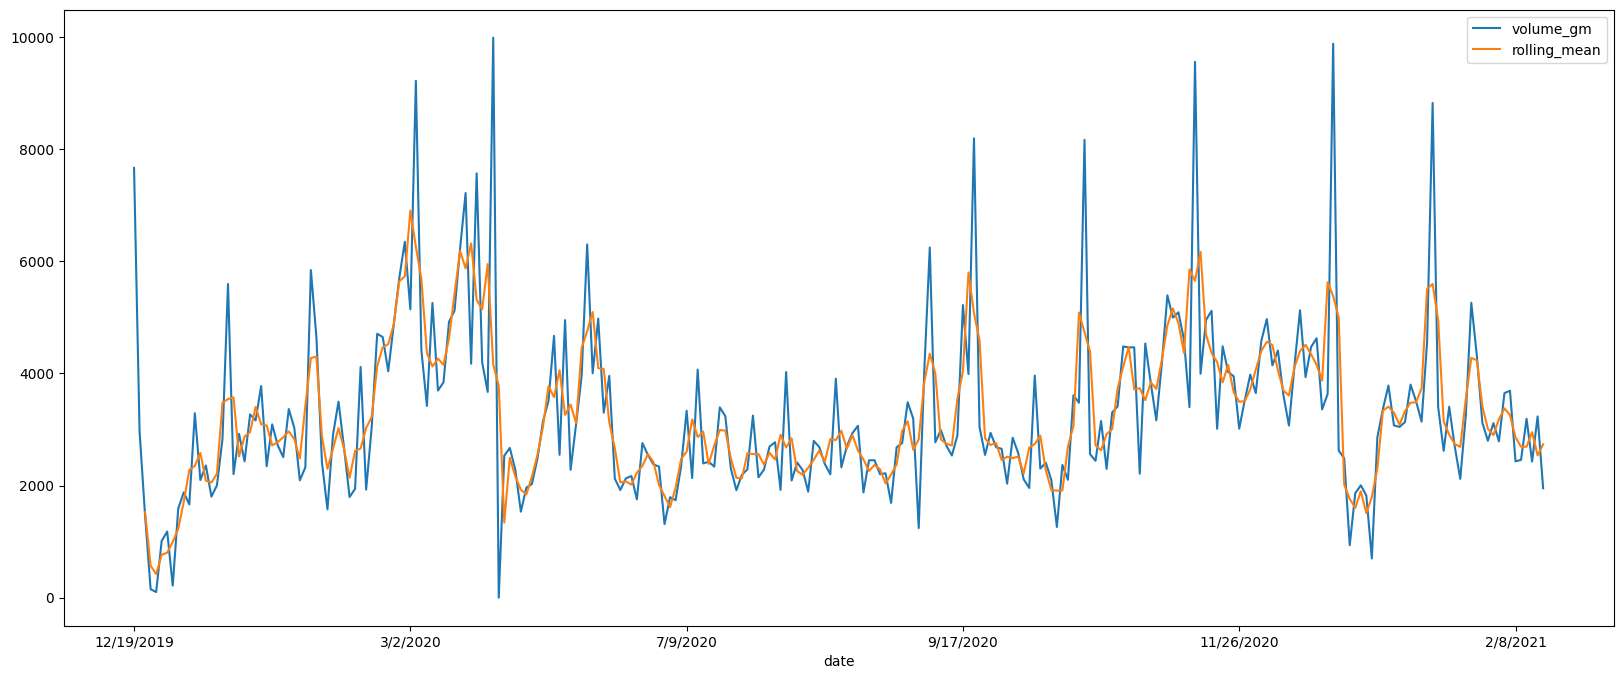

In [187]:
test_lag_df["volume_gm"].plot(figsize=[20, 8], legend=True)
test_df['rolling_mean'].plot(figsize=[20, 8], legend=True)

In [188]:
rolling_mean_vals = test_lag_df["rolling_mean"].dropna()
rolling_mean_vals

date
12/23/2019    1524.509122
12/24/2019     570.319404
12/26/2019     421.834123
12/27/2019     764.509557
12/30/2019     802.682240
                 ...     
2/9/2021      2692.773386
2/10/2021     2691.823343
2/11/2021     2950.032393
2/12/2021     2536.919923
2/15/2021     2735.533430
Name: rolling_mean, Length: 254, dtype: float64

In [189]:
sml_target_vals = test_lag_df["sml_target"].loc[rolling_mean_vals.index]
sml_target_vals

date
12/23/2019     151.678597
12/24/2019     101.194918
12/26/2019    1012.628855
12/27/2019    1179.704897
12/30/2019     215.712969
                 ...     
2/9/2021      3190.066116
2/10/2021     2427.720356
2/11/2021     3232.310708
2/12/2021     1950.728704
2/15/2021     3023.560878
Name: sml_target, Length: 254, dtype: float64

In [190]:
gm_target_vals = test_lag_df["volume_gm"].loc[rolling_mean_vals.index]
gm_target_vals

date
12/23/2019    1458.084698
12/24/2019     151.678597
12/26/2019     101.194918
12/27/2019    1012.628855
12/30/2019    1179.704897
                 ...     
2/9/2021      2457.683556
2/10/2021     3190.066116
2/11/2021     2427.720356
2/12/2021     3232.310708
2/15/2021     1950.728704
Name: volume_gm, Length: 254, dtype: float64

In [191]:
print(f"MAE TS: {mean_absolute_error(gm_target_vals.values, rolling_mean_vals.values)}")
print(f"RMSE TS: {root_mean_squared_error(gm_target_vals.values, rolling_mean_vals.values)}")
print(f"R2 TS: {r2_score(gm_target_vals.values, rolling_mean_vals.values)}")

MAE TS: 657.3912222406824
RMSE TS: 1024.1148940520409
R2 TS: 0.5697464723702388


In [192]:
print(f"MAE ML: {mean_absolute_error(sml_target_vals.values, rolling_mean_vals.values)}")
print(f"RMSE ML: {root_mean_squared_error(sml_target_vals.values, rolling_mean_vals.values)}")
print(f"R2 ML: {r2_score(sml_target_vals.values, rolling_mean_vals.values)}")

MAE ML: 714.2344719120734
RMSE ML: 1050.5203311945409
R2 ML: 0.5515357225331949


#### SHAP

In [193]:
def evaluate_feature_importance(df: pd.DataFrame, features, target, model=None, threshold=0.95, plot=True):
    if model is None:
        warnings.warn("Feature Importance: model is not specified, using CatBoostRegressor", UserWarning)
        model = CatBoostRegressor()
    X = df[features]
    y = df[[target]]
    model.fit(X,
            y,
            verbose=0,
            plot=False)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    feature_importance = pd.DataFrame(shap_values, columns=features).abs().sum().sort_values(ascending=False)
    feature_importance_normalized = feature_importance / feature_importance.sum()
    cumulative_importance = feature_importance_normalized.cumsum()
    idx = np.where(cumulative_importance > threshold)[0][0]

    if plot:
        shap.summary_plot(shap_values, X)
        plt.plot(range(len(cumulative_importance)), cumulative_importance)
        plt.axvline(x=idx, color='g', linestyle='--', label=f'Optimal Number of Features ({idx})')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Importance')
        plt.legend()
        plt.show()

    top_features = feature_importance[cumulative_importance <= threshold].index
    return top_features

/var/folders/hg/wkh3wd0x2cdgx68tgss9y0cr0000gn/T/ipykernel_48294/2409296823.py:3: UserWarning: Feature Importance: model is not specified, using CatBoostRegressor
  warnings.warn("Feature Importance: model is not specified, using CatBoostRegressor", UserWarning)


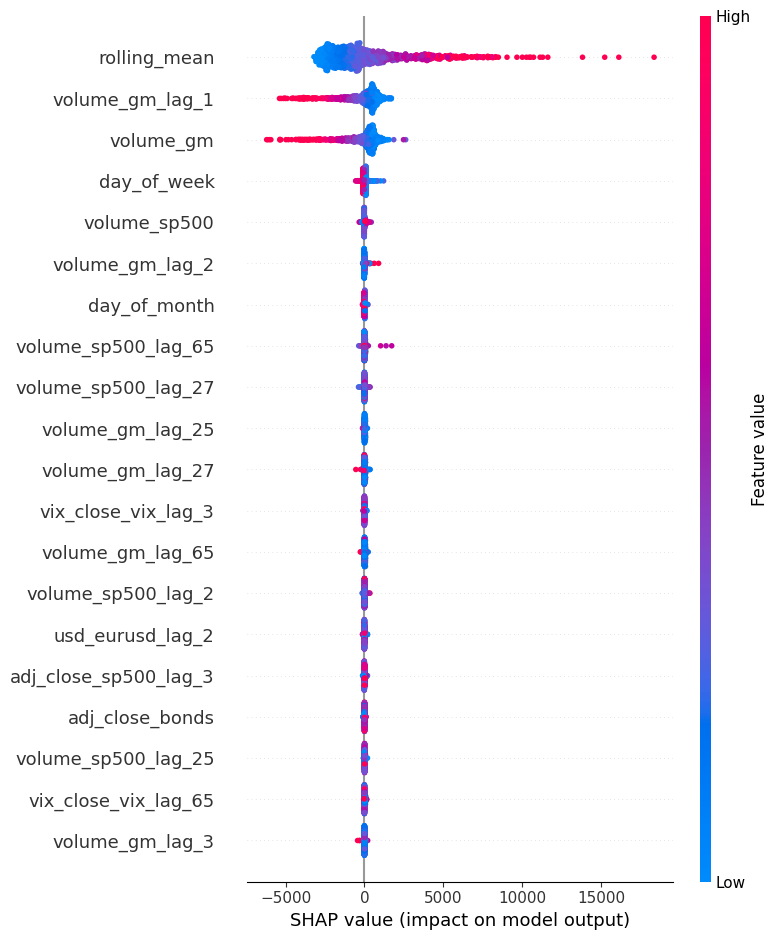

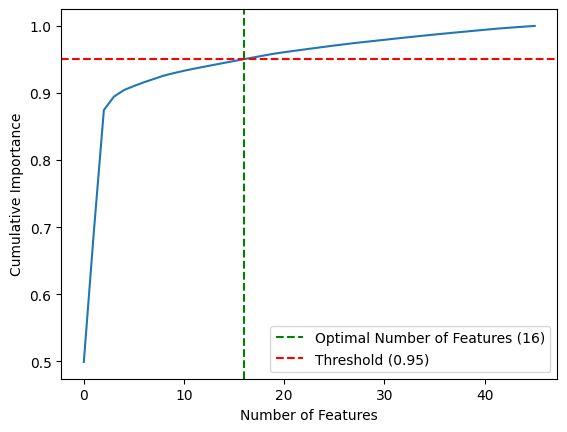

In [194]:
features = [col for col in train_lags_df if col != "sml_target" and "gold" not in col]
top_features = evaluate_feature_importance(train_lags_df, features, target="sml_target")

In [196]:
top_features

Index(['rolling_mean', 'volume_gm_lag_1', 'volume_gm', 'day_of_week',
       'volume_sp500', 'volume_gm_lag_2', 'day_of_month',
       'volume_sp500_lag_65', 'volume_sp500_lag_27', 'volume_gm_lag_25',
       'volume_gm_lag_27', 'vix_close_vix_lag_3', 'volume_gm_lag_65',
       'volume_sp500_lag_2', 'usd_eurusd_lag_2', 'adj_close_sp500_lag_3'],
      dtype='object')

In [197]:
my_features = top_features

#### XGBoost

In [198]:
X_train = train_lags_df[my_features]
y_train = train_lags_df[["sml_target"]]
X_test = test_lag_df[my_features]
y_test = test_lag_df[["sml_target"]]

In [202]:
def log_transform(x):
    print(x)
    return np.log(x + 1)


preprocessor = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        #("log_transformer", FunctionTransformer(log_transform))
    ]
)
xgb_model = xgb.XGBRegressor(
    eval_metric=root_mean_squared_error,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8
)

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", xgb_model)])

In [200]:
param_grid = {

    'model__learning_rate': [0.01, 0.1, 0.2],

    'model__max_depth': [3, 5, 7],

    'model__subsample': [0.8, 0.9, 1.0]

}

random_search = RandomizedSearchCV(pipe, param_grid, cv=3)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_params

{'model__subsample': 0.8, 'model__max_depth': 3, 'model__learning_rate': 0.1}

In [203]:
# Train
pipe.fit(X_train, y_train)

preds_ = pipe.predict(X_test)

print(f"MAE: {mean_absolute_error(y_test, preds_)}")
print(f"RMSE: {root_mean_squared_error(y_test, preds_)}")
print(f"R2: {r2_score(y_test, preds_)}")

MAE: 315.6057217254242
RMSE: 465.56744606832797
R2: 0.9117057841637589


<Axes: xlabel='date'>

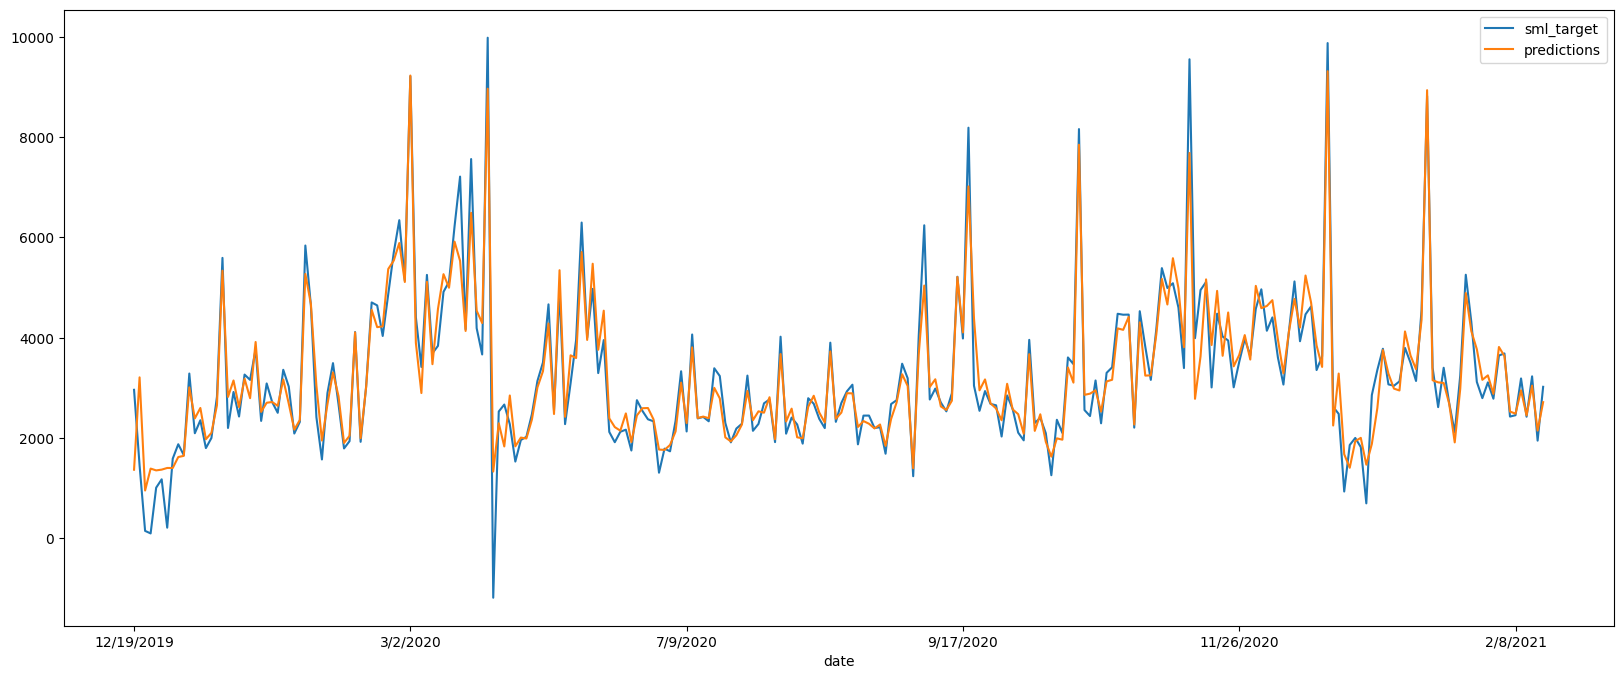

In [204]:
test_lag_df["predictions"] = preds_
test_lag_df["sml_target"].plot(figsize=[20, 8], legend=True)
test_lag_df['predictions'].plot(figsize=[20, 8], legend=True)

#### CatBoost